In [1]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder

assert numpyro.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
import geopandas as gpd
plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [177]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [178]:
df = df[df.date > '2021-10-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x == 'BA.1')))
all = df.groupby(['sending_pc','date'])['omi'].count()
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy().dropna()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)

df_filtered = df_filtered.merge(bland, left_on='sending_pc', right_index=True)#.dropna()
df_filtered['bundesland'] = pd.Categorical(df_filtered['bundesland'].values)

omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['bundesland'].values.codes

In [179]:
df_filtered

sending_pc       date  all  omi  days  sending_area  sending_pc_ID  \
0          01067 2021-10-02    0    0  -100             0              0   
1          01067 2021-10-03    0    0   -99             0              0   
2          01067 2021-10-04    0    0   -98             0              0   
3          01067 2021-10-05   11    0   -97             0              0   
4          01067 2021-10-06    0    0   -96             0              0   
...          ...        ...  ...  ...   ...           ...            ...   
24410      90530 2021-12-31    0    0   -10             9             92   
24411      90530 2022-01-01    0    0    -9             9             92   
24412      90530 2022-01-02    0    0    -8             9             92   
24413      90530 2022-01-03    0    0    -7             9             92   
24414      90530 2022-01-04    0    0    -6             9             92   

      bundesland  
0        Sachsen  
1        Sachsen  
2        Sachsen  
3        Sachsen  
4        Sachsen  
...          ...  
24410     Bayern  
24411     Bayern  
24412     Bayern  
24413     Bayern  
24414     Bayern  

[10355 rows x 8 columns]

In [183]:
foo = df_filtered.set_index(['bundesland','sending_pc','date']).sort_index()
foo = foo.sum(level=[0,2]).loc[:,"2021-11-20":,:]
foo['prop'] = foo.omi / foo['all']
for i,r in enumerate(foo.index.levels[0]):
    foo.loc[r]['prop'].plot(ls="", marker="." if i < 10 else "x", label=r)
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.yscale('logit')
plt.ylabel("Omicron proportion")
plt.xlim((None, np.datetime64("today")))

(18951.0, 19002.0)

In [7]:
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {k: LocScaleReparam(0) for k in ["mu_a", "a"]}

@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sending_area, sending_pc_to_area, sample_day, total_counts,omi_counts=None):
    mu_a_mu = numpyro.sample("mu_a_mu", dist.Normal(0, 3.0))
    mu_a_sigma = numpyro.sample("mu_a_sigma", dist.HalfNormal(2.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(2.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.2, 0.2))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(.1))


    n_labs = len(np.unique(sending_pc))
    n_areas = len(np.unique(sending_pc_to_area))

    with numpyro.plate("plate_i", n_areas):
        mu_a = numpyro.sample("mu_a", dist.Normal(mu_a_mu, mu_a_sigma))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

    with numpyro.plate("plate_j", n_labs):
        a = numpyro.sample("a", dist.Normal(mu_a[sending_pc_to_area], sigma_a))
    
    logit_est = a[sending_pc] + b[sending_area] * sample_day

    with numpyro.plate("data", len(sending_pc)):
        numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)


In [184]:
sending_pc_to_area = pd.DataFrame({"sending_pc": sending_pc_ID, "sending_area": sending_area}).groupby(['sending_pc']).sending_area.first().values

In [185]:
nuts_kernel = NUTS(model3)

mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sending_pc_ID, sending_area, sending_pc_to_area, sample_day, total_counts, omi_counts=omi_counts)

sample: 100%|██████████| 7000/7000 [37:04<00:00,  3.15it/s, 1023 steps of size 1.67e-03. acc. prob=0.82]


In [186]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
    a_decentered[0]     -1.01      0.42     -1.00     -1.67     -0.31    249.18      1.00
    a_decentered[1]     -0.57      0.41     -0.57     -1.24      0.09    244.80      1.00
    a_decentered[2]      0.39      0.62      0.42     -0.57      1.44    463.72      1.00
    a_decentered[3]     -1.59      0.62     -1.55     -2.56     -0.57    665.08      1.00
    a_decentered[4]     -0.85      0.50     -0.84     -1.66     -0.03    295.59      1.00
    a_decentered[5]     -0.35      0.71     -0.35     -1.43      0.91    552.66      1.00
    a_decentered[6]      0.60      0.44      0.59     -0.15      1.28    287.23      1.00
    a_decentered[7]      1.12      0.64      1.13      0.14      2.23    683.98      1.00
    a_decentered[8]      1.58      0.40      1.55      0.95      2.24    179.20      1.01
    a_decentered[9]     -1.12      0.77     -1.11     -2.32      0.22    610.48      1.00
   a_dece

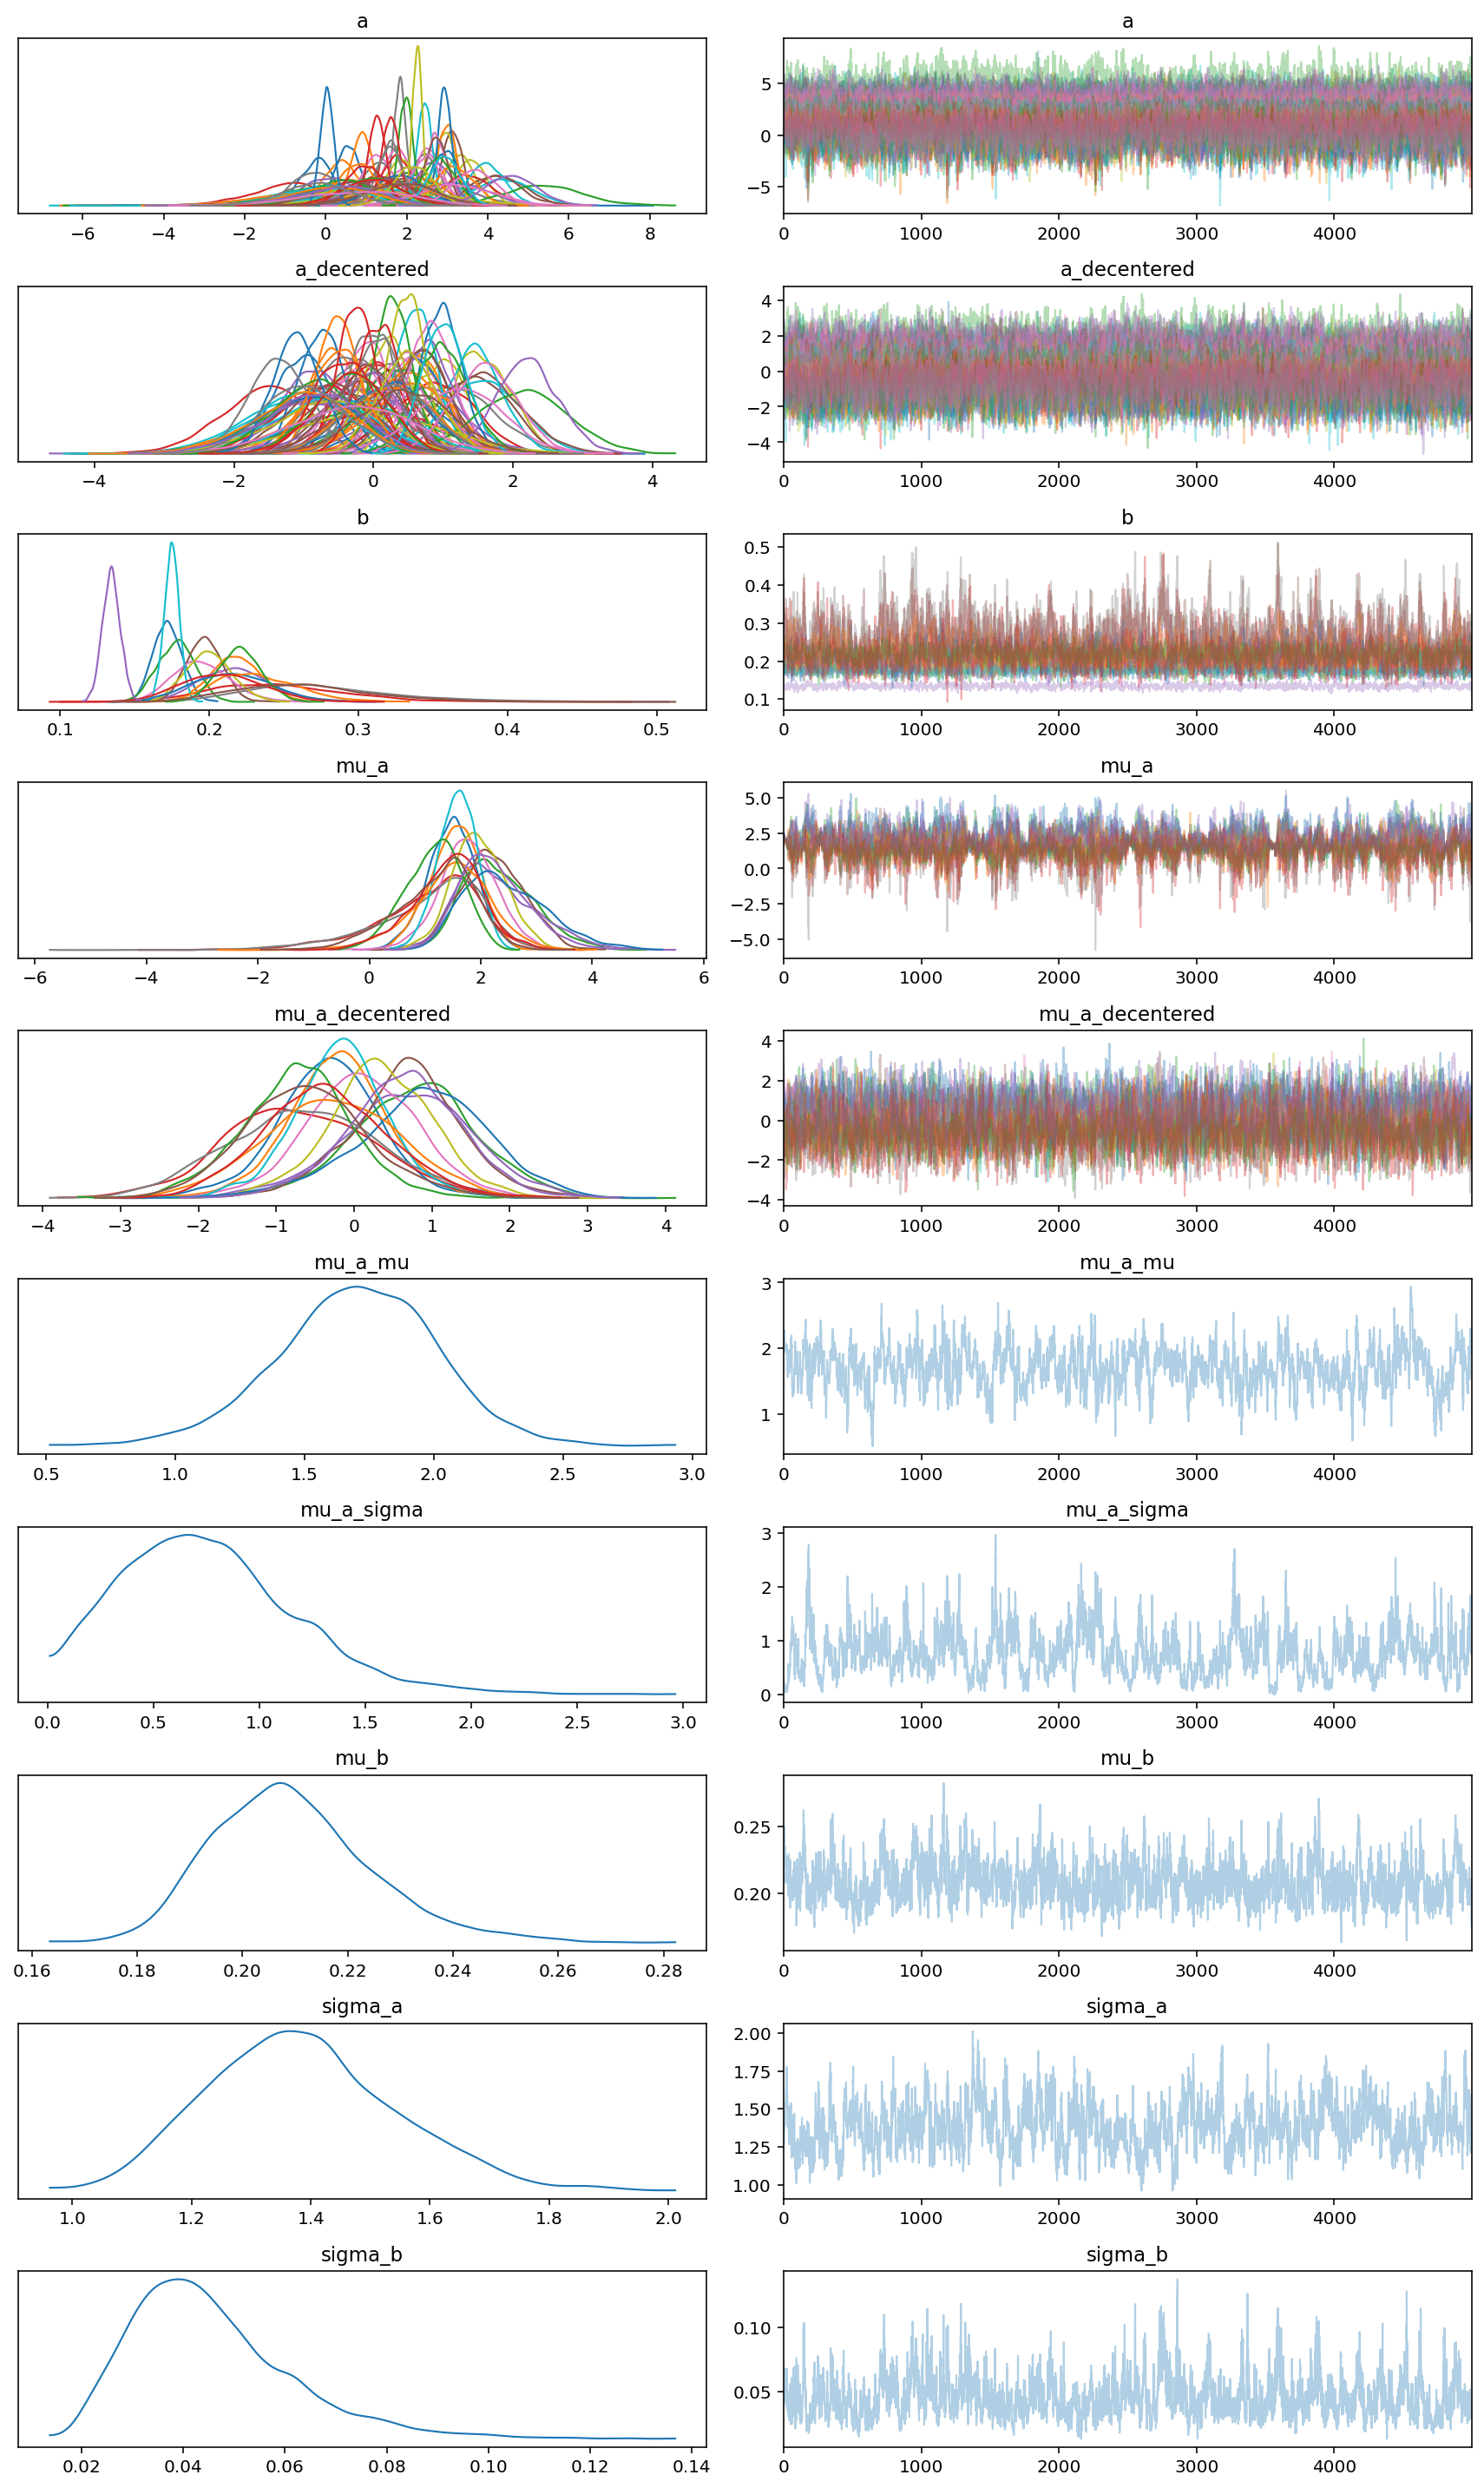

In [187]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [188]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)
s = numpyro.diagnostics.summary(mcmc_samples)

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(s['mu_b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(s['mu_b']['5.0%'])-1:.1%}, {np.exp(s['mu_b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+s['mu_b']['mean']):.2} Tage mit 90%-Konfidenzintervall [{np.log(2)/np.log(1+s['mu_b']['95.0%']):.2},{np.log(2)/np.log(1+s['mu_b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    23.3% mit 90%-Konfidenzintervall [20.3%, 26.2%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    3.6 Tage mit 90%-Konfidenzintervall [3.3,4.1]
    


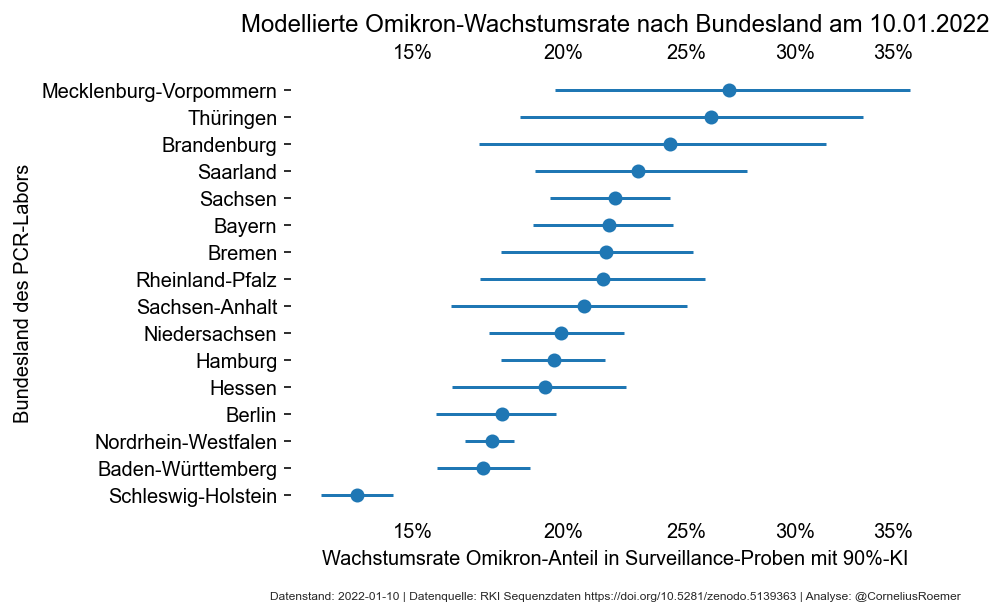

In [189]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
pdf = pd.DataFrame(s['b'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([(pdf['median'])-(pdf['5.0%']),(pdf['95.0%'])-(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierte Omikron-Wachstumsrate nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Wachstumsrate Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [14]:
list(df_filtered.bundesland.values.categories)

['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen']

In [15]:
q = [0.05,0.5,0.95]
t = (np.arange("2021-12-01","2022-01-31", dtype='datetime64[D]') - np.datetime64("today")).astype("int")
prop_bl = pd.Series(expit(np.quantile(mcmc_samples['mu_a'][0][...,np.newaxis] + mcmc_samples['b'][0][...,np.newaxis] * t[np.newaxis,np.newaxis,:], 
                                     q,
                                     axis = 0)).flatten(),
                         index = pd.MultiIndex.from_product([q, 
                                                             df_filtered.bundesland.values.categories,
                                                             np.datetime64("today") + t.astype("timedelta64[D]")],
                                                           names=['quantile',
                                                                  'bundesland',
                                                                  'date']),
                       )
prop_bl = prop_bl.reset_index().set_index(["bundesland","date","quantile"])#.pivot(columns="quantile")

In [191]:
prop_bl

0
bundesland        date       quantile          
Baden-Württemberg 2021-12-01 0.05      0.000903
                  2021-12-02 0.05      0.001081
                  2021-12-03 0.05      0.001295
                  2021-12-04 0.05      0.001555
                  2021-12-05 0.05      0.001869
...                                         ...
Thüringen         2022-01-26 0.95      0.998960
                  2022-01-27 0.95      0.999253
                  2022-01-28 0.95      0.999458
                  2022-01-29 0.95      0.999606
                  2022-01-30 0.95      0.999714

[2928 rows x 1 columns]

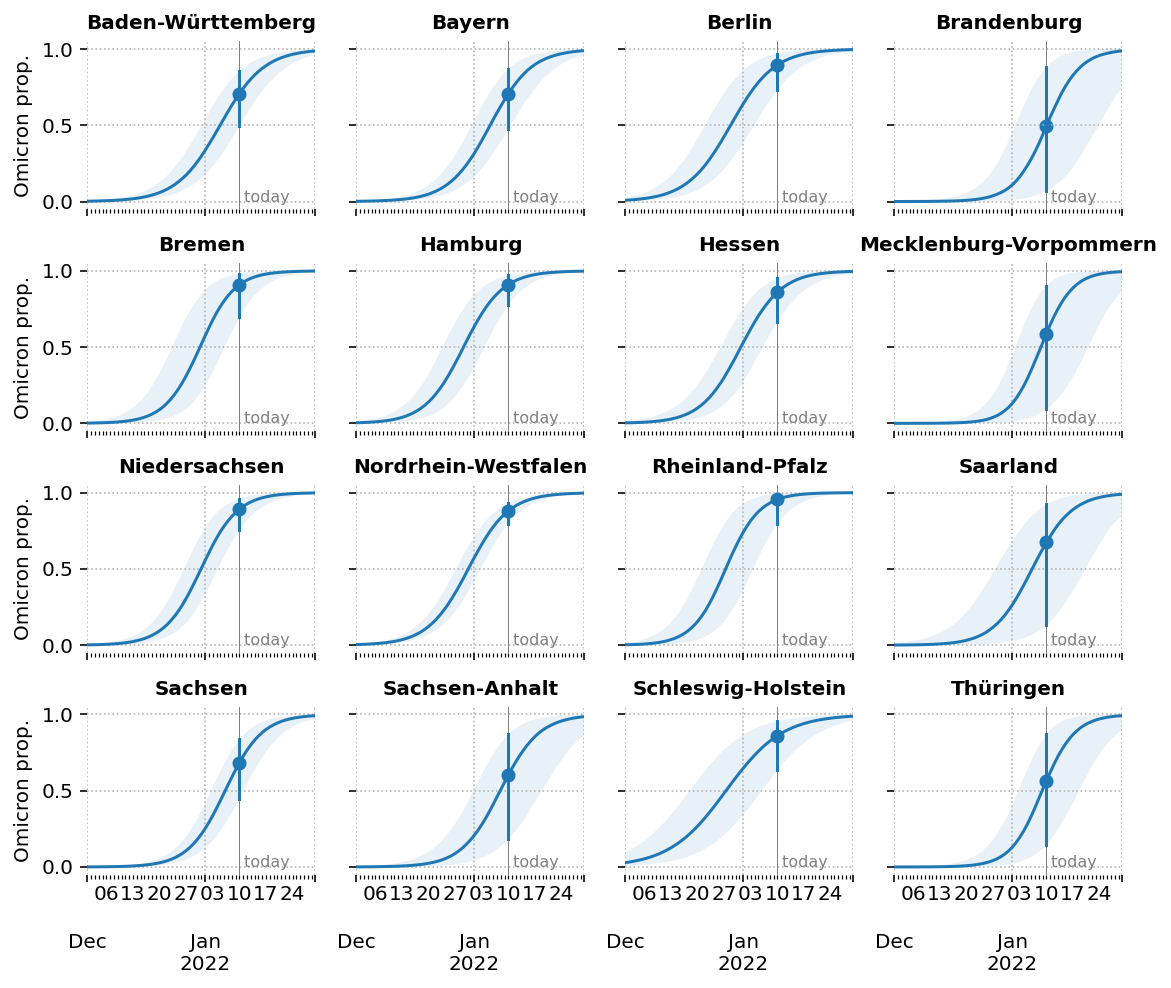

In [194]:
sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    prop_bl.loc[r,:,0.5][0].plot(label=r, ax=ax[i])
    ax[i].fill_between(prop_bl.loc[r,:,0.05][0].index, prop_bl.loc[r,:,0.05][0], prop_bl.loc[r,:,0.95][0], alpha=0.1)
    ax[i].set_title(r, size=10, weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Omicron prop.")
    ax[i].axvline(np.datetime64("today"), color='grey', lw=0.5)
    ax[i].text(np.datetime64("today"),0.0, " today", size=8, color='grey')
    ax[i].plot(np.repeat(np.datetime64("today"),2), prop_bl.loc[r,np.datetime64("today"),[0.05,0.95]], c='C0')
    ax[i].scatter(np.datetime64("today"), prop_bl.loc[r,np.datetime64("today"),0.5], c='C0')
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
plt.tight_layout()

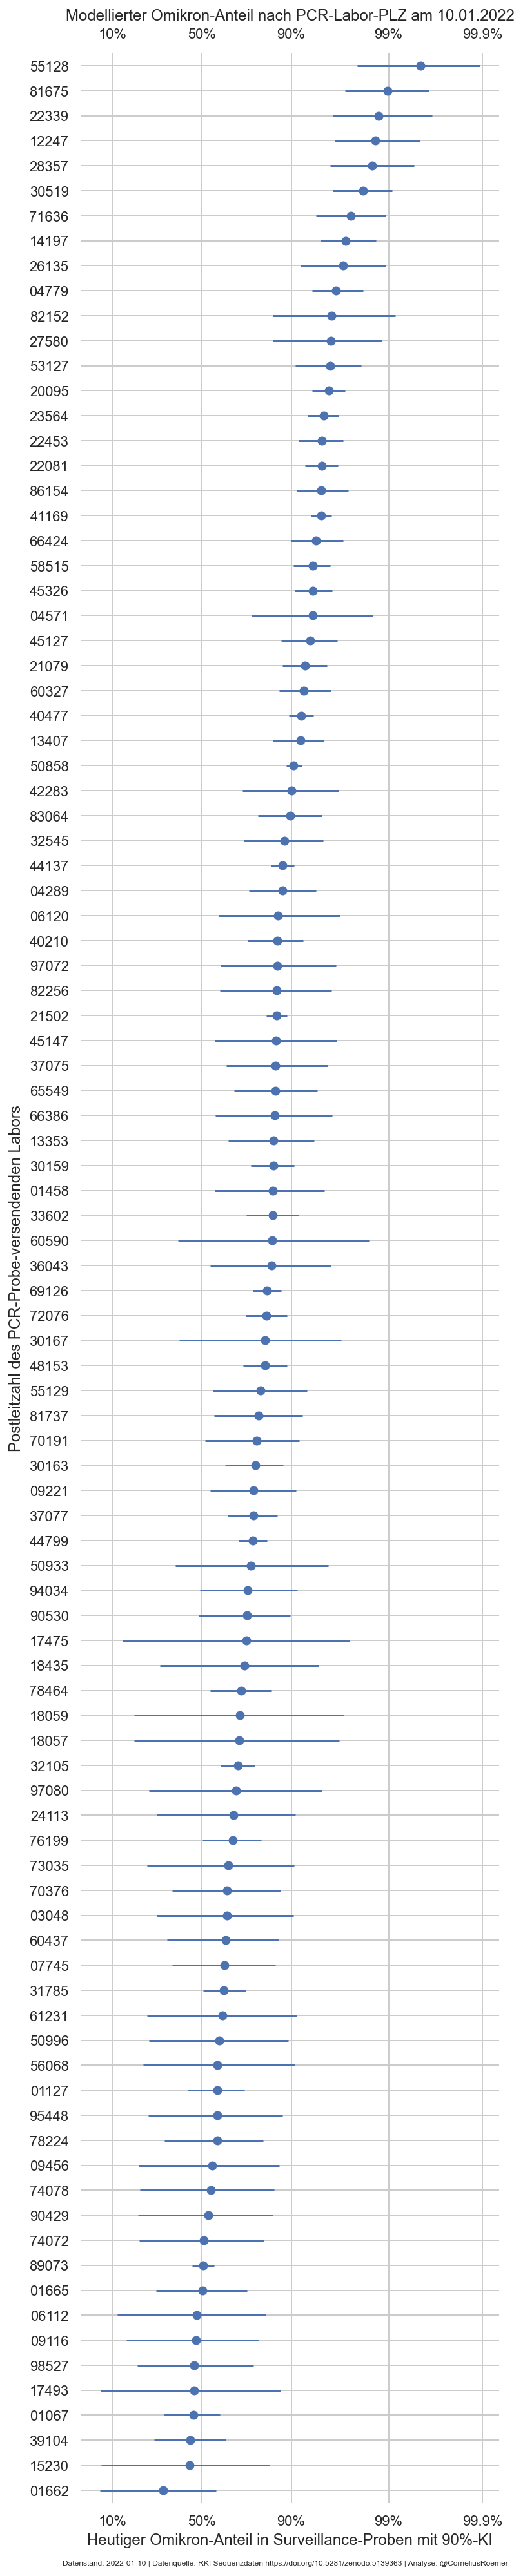

In [195]:
pdf = pd.DataFrame(s['a'])
pdf['plz'] = le.inverse_transform(pdf.index.values)
pdf.set_index('plz',inplace=True)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5,30)) 
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values,xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.set(title=f'Modellierter Omikron-Anteil nach PCR-Labor-PLZ am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.02)
fig.text(0.49, -0.003, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_pc.png",dpi=300,bbox_inches='tight',pad_inches=0.2)

Es gibt drei klare Ausreißer die entfernt wurden. Für mehr Details zu Outliern siehe das Notebook [Outlier Labs](outlier_labs.ipynb).

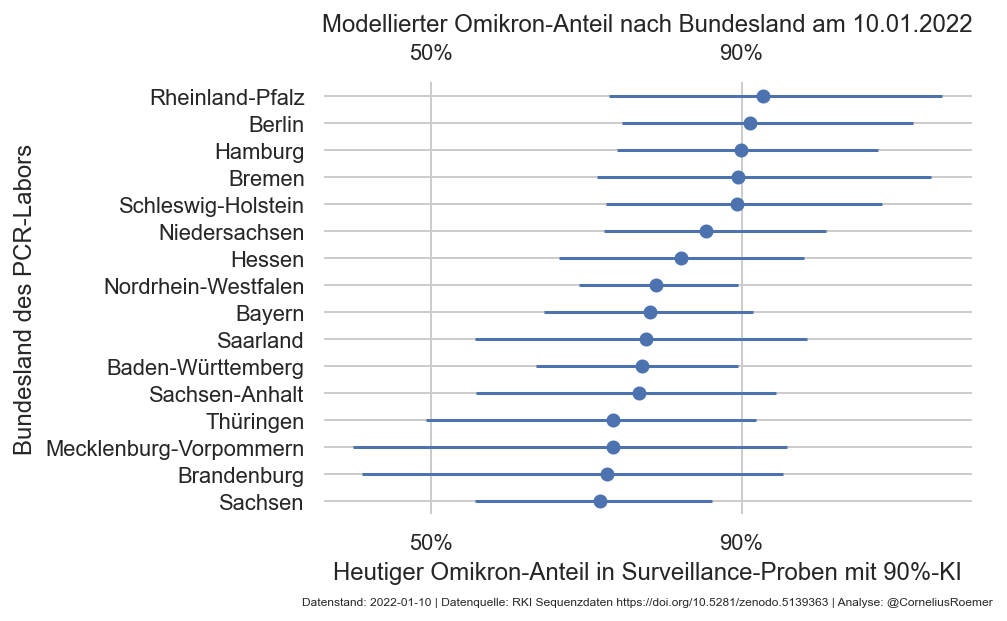

In [196]:
pdf = pd.DataFrame(s['mu_a'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [19]:
bl = plz.dissolve(by = 'bundesland')
bl.geometry = bl.simplify(1e-2, preserve_topology=False)

In [20]:
bl['land'] = "Deutschland"

In [21]:
bl

geometry  \
bundesland                                                                  
#N/A                    POLYGON ((6.83623 49.21127, 6.85915 49.22275, ...   
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...   
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...   
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...   
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...   
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...   
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...   
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...   
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...   
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...   
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...   
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...   
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...   
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...   
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...   
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...   
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...   

                        OBJECTID    plz       ags                ort  \
bundesland                                                             
#N/A                         409  57540      #N/A               #N/A   
Baden-Württemberg           1129  79588  08336014   Efringen-Kirchen   
Bayern                      3150  63791  09671114  Karlstein am Main   
Berlin                      8042  14109  11000000             Berlin   
Brandenburg                 6380  19309  12070236               Lanz   
Bremen                      2400  28777  04011000             Bremen   
Hamburg                     2308  27499  02000000            Hamburg   
Hessen                      1486  65391  06439010              Lorch   
Mecklenburg-Vorpommern      5574  19258  13076009        Bengerstorf   
Niedersachsen                253  26757  03457002             Borkum   
Nordrhein-Westfalen            1  52538  05370008            Gangelt   
Rheinland-Pfalz               24  54689  07232001             Affler   
Saarland                      92  66706  10042115               Perl   
Sachsen                     7046  08538  14523450         Weischlitz   
Sachsen-Anhalt              5540  38835  15085230         Osterwieck   
Schleswig-Holstein          1625  27498  01056025          Helgoland   
Thüringen                   4517  36419  16063011            Buttlar   

                                            landkreis  einwohner  \
bundesland                                                         
#N/A                                             #N/A        0.0   
Baden-Württemberg                   Landkreis Lörrach     8205.0   
Bayern                        Landkreis Aschaffenburg     8023.0   
Berlin                                           None    10049.0   
Brandenburg                        Landkreis Prignitz     3684.0   
Bremen                                           None    12969.0   
Hamburg                                          None        8.0   
Hessen                          Rheingau-Taunus-Kreis     3994.0   
Mecklenburg-Vorpommern  Landkreis Ludwigslust-Parchim    15989.0   
Niedersachsen                          Landkreis Leer     5207.0   
Nordrhein-Westfalen                   Kreis Heinsberg    21390.0   
Rheinland-Pfalz               Eifelkreis Bitburg-Prüm     2326.0   
Saarland                      Landkreis Merzig-Wadern     7791.0   
Sachsen                                 Vogtlandkreis     6264.0   
Sachsen-Anhalt                         Landkreis Harz    10404.0   
Schleswig-Holstein                    Kreis Pinneberg     1407.0   
Thüringe

In [22]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Text(0.5, 1.0, 'Omicron growth advantage $s = r_{Omicron} - r_{Delta}$')

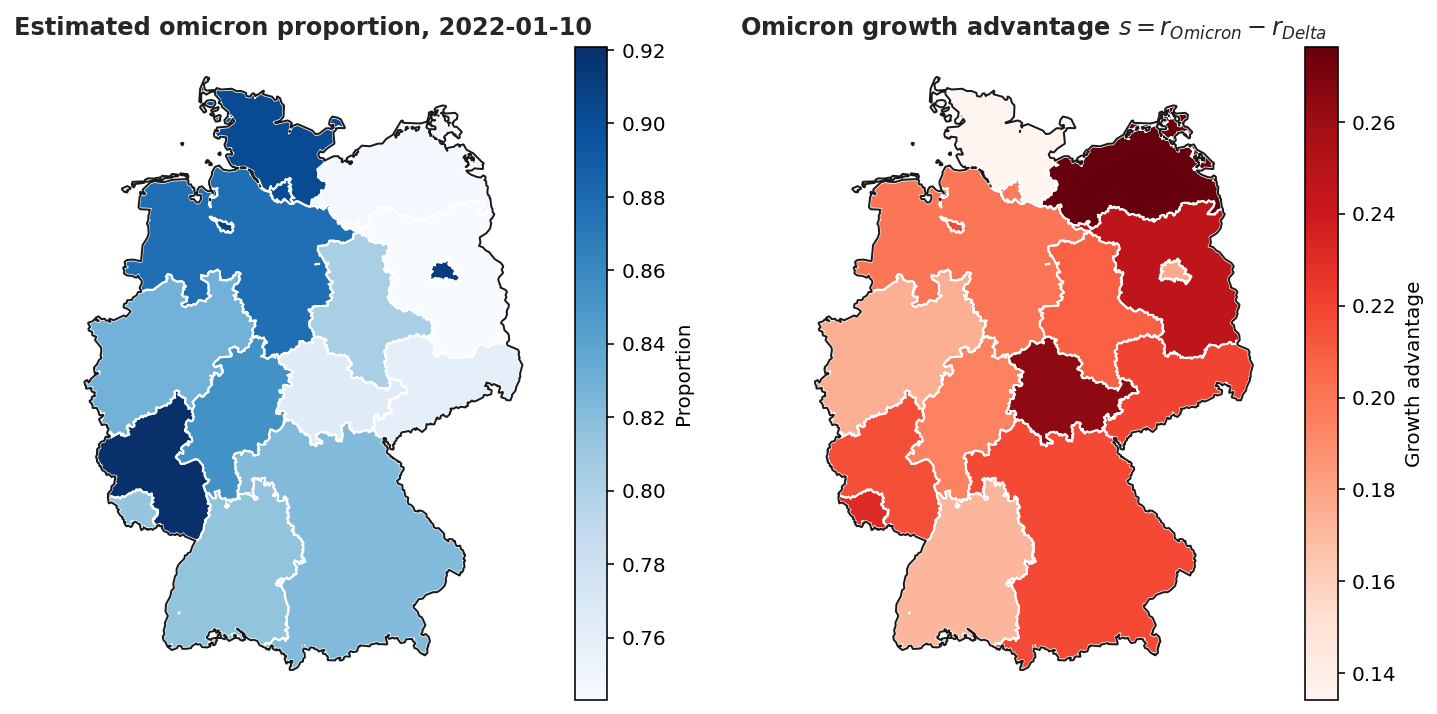

In [197]:
#sns.set_style("white")
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
pdf = pd.DataFrame({'prop':expit(s['mu_a']['mean']),
                    'prop_5%':expit(s['mu_a']['5.0%']),
                    'prop_95%':expit(s['mu_a']['95.0%']),
                    's': s['b']['mean'],
                    's_sd': s['b']['std']},
                   index=df_filtered.bundesland.values.categories)

b = bl.merge(pdf, left_index=True, right_index=True)
b.plot("prop", lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Proportion"},
            figsize=(6,6),
       ax = ax[0]
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())


b.boundary.plot(color='w',lw=1, ax=ax[0])
de.boundary.plot(color='k',lw=1, ax=ax[0])

ax[0].axis('off')
ax[0].set_title(f"Estimated omicron proportion, {np.datetime64('today')}", weight='bold')

b.plot("s", lw=1, cmap="Reds", 
            legend=True,
            legend_kwds={'label': "Growth advantage"},
            figsize=(6,6),
       ax = ax[1]
           )
b.boundary.plot(color='w',lw=1, ax=ax[1])
de.boundary.plot(color='k',lw=1,  ax=ax[1])

ax[1].axis('off')
ax[1].set_title("Omicron growth advantage $s = r_{Omicron} - r_{Delta}$", weight='bold')


In [200]:
bar = foo.reset_index()
bar['week'] = bar.date - pd.to_timedelta(bar.date.dt.dayofweek, unit='d')
bar = bar.set_index(['bundesland', 'week','date']).sum(level=(0,1))
bar['prop'] = bar.omi/bar['all']
bar['prop']

bundesland         week      
Baden-Württemberg  2021-11-15    0.000000
                   2021-11-22    0.000652
                   2021-11-29    0.006645
                   2021-12-06    0.009434
                   2021-12-13    0.016925
                                   ...   
Thüringen          2021-12-06    0.000000
                   2021-12-13    0.000000
                   2021-12-20    0.000000
                   2021-12-27    0.068493
                   2022-01-03         NaN
Name: prop, Length: 128, dtype: float64

(2707.0, 2715.0)

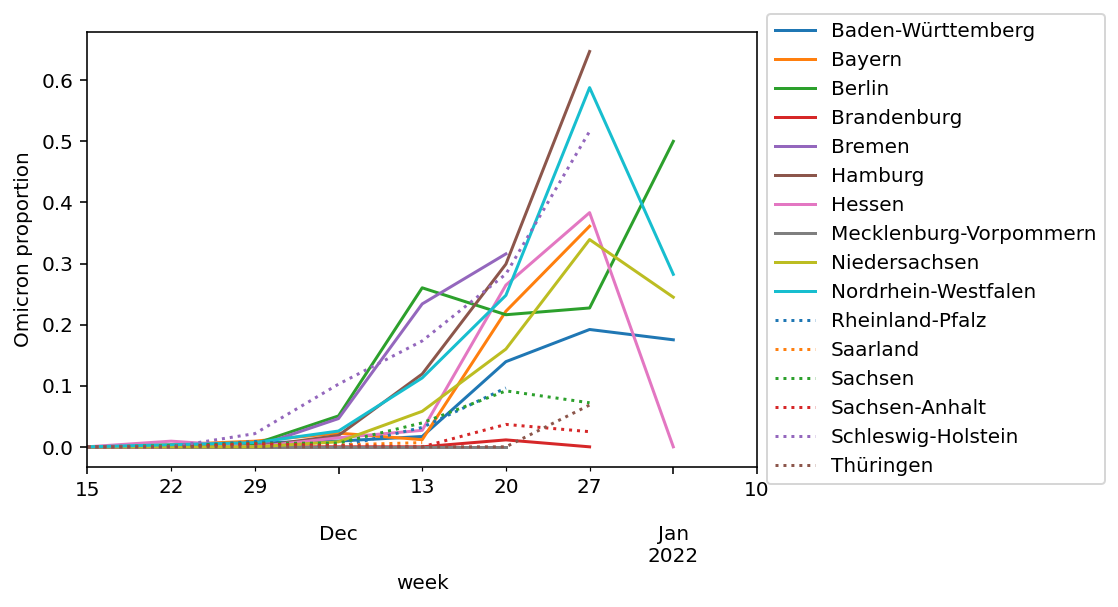

In [207]:
for i,r in enumerate(bar.index.levels[0]):
    bar.loc[r]['prop'].plot( label=r, ls = "-" if i <10 else ":")
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Omicron proportion")
plt.xlim((None,np.datetime64("today")))

In [210]:
bar.loc[:,'2021-12-20':,:]

all  omi  days  sending_area  \
bundesland             week                                       
Baden-Württemberg      2021-12-20  373   52 -1512           588   
                       2021-12-27  604  116  -924           588   
                       2022-01-03  137   24  -156           168   
Bayern                 2021-12-20  347   77 -1512           714   
                       2021-12-27   36   13  -924           714   
                       2022-01-03    0    0  -156           204   
Berlin                 2021-12-20   37    8  -504            28   
                       2021-12-27   22    5  -308            28   
                       2022-01-03    2    1   -52             8   
Brandenburg            2021-12-20   88    1  -252             7   
                       2021-12-27    6    0  -154             7   
                       2022-01-03    0    0   -26             2   
Bremen                 2021-12-20   19    6  -252            28   
                       2021-12-27    0    0  -154            28   
                       2022-01-03    0    0   -26             8   
Hamburg                2021-12-20  321   96  -882            98   
                       2021-12-27  204  132  -539            98   
                       2022-01-03    0    0   -91            28   
Hessen                 2021-12-20  102   27  -630           189   
                       2021-12-27   60   23  -385           189   
                       2022-01-03    1    0   -65            54   
Mecklenburg-Vorpommern 2021-12-20  103    0 -1008            56   
                       2021-12-27    0    0  -616            56   
                       2022-01-03    0    0  -104            16   
Niedersachsen          2021-12-20  150   24 -1134           182   
                       2021-12-27  112   38  -693           182   
                       2022-01-03   49   12  -117            52   
Nordrhein-Westfalen    2021-12-20  984  244 -2394           546   
                       2021-12-27  614  361 -1463           546   
                       2022-01-03   85   24  -247           156   
Rheinland-Pfalz        2021-12-20   83    8  -378           105   
                       2021-12-27    0    0  -231           105   
                       2022-01-03    0    0   -39            30   
Saarland               2021-12-20    0    0  -252            84   
                       2021-12-27   78   45  -154            84   
                       2022-01-03    0    0   -26            24   
Sachsen                2021-12-20  677   62 -1638             0   
                       2021-12-27  208   15 -1001             0   
                       2022-01-03    0    0  -169             0   
Sachsen-Anhalt         2021-12-20  109    4  -378            21   
                       2021-12-27  121    3  -231            21   
                       2022-01-03    0    0   -39             6   
Schleswig-Holstein     2021-12-20  336   95  -504            56   
                       2021-12-27  335  173  -308            56   
                       2022-01-03    0    0   -52            16   
Thüringen              2021-12-20  166    0  -504           189   
                       2021-12-27   73    5  -308           189   
                       2022-01-03    0    0   -52            54   

                                   sending_pc_ID      prop  
bundesland             week                                 
Baden-Württemberg      2021-12-20           6636  0.139410  
                       2021-12-27           6636  0.192053  
                       2022-01-03           1896  0.175182  
Bayern                 2021-12-20           7560  0.221902  
                       2021-12-27           7560  0.361111  
                       2022-01-03           2160       NaN  
Berlin                 2021-12-20            462  0.216216  
                       2021-12-27            462  0.227273  
                       2022-01-03            132  0.500000  
Brandenburg  

In [211]:
cases = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [212]:
cases = cases['AnzahlFall'].sum(level=(0,3)).sort_index()

In [213]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [214]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-05         871
                  2022-01-06         640
                  2022-01-07         455
                  2022-01-08         417
                  2022-01-09         223

[11121 rows x 1 columns]

Text(0, 0.5, 'cases')

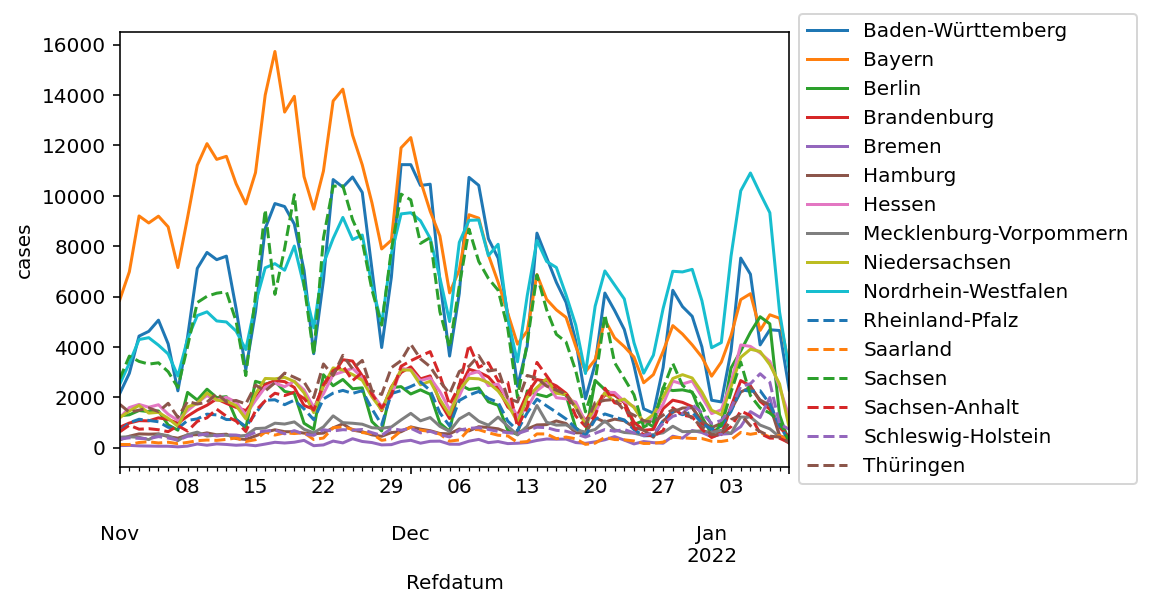

In [215]:
for i,r in enumerate(cases_land.index.levels[0]):
    cases_land.loc[r].loc["2021-11-01":,'AnzahlFall'].plot(label=r, ls="-" if i<10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel('cases')
#plt.xlim("")

In [216]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   211    0 -1212           168           1896   
                  2021-11-22  1533    1 -3864           588           6636   
                  2021-11-29   903    6 -3276           588           6636   
                  2021-12-06   954    9 -2688           588           6636   
                  2021-12-13   709   12 -2100           588           6636   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-06   143    0  -896           189           2135   
                  2021-12-13   240    0  -700           189           2135   
                  2021-12-20   166    0  -504           189           2135   
                  2021-12-27    73    5  -308           189           2135   
                  2022-01-03     0    0   -52            54            610   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000652  
                  2021-11-29  0.006645  
                  2021-12-06  0.009434  
                  2021-12-13  0.016925  
...                                ...  
Thüringen         2021-12-06  0.000000  
                  2021-12-13  0.000000  
                  2021-12-20  0.000000  
                  2021-12-27  0.068493  
                  2022-01-03       NaN  

[128 rows x 6 columns]

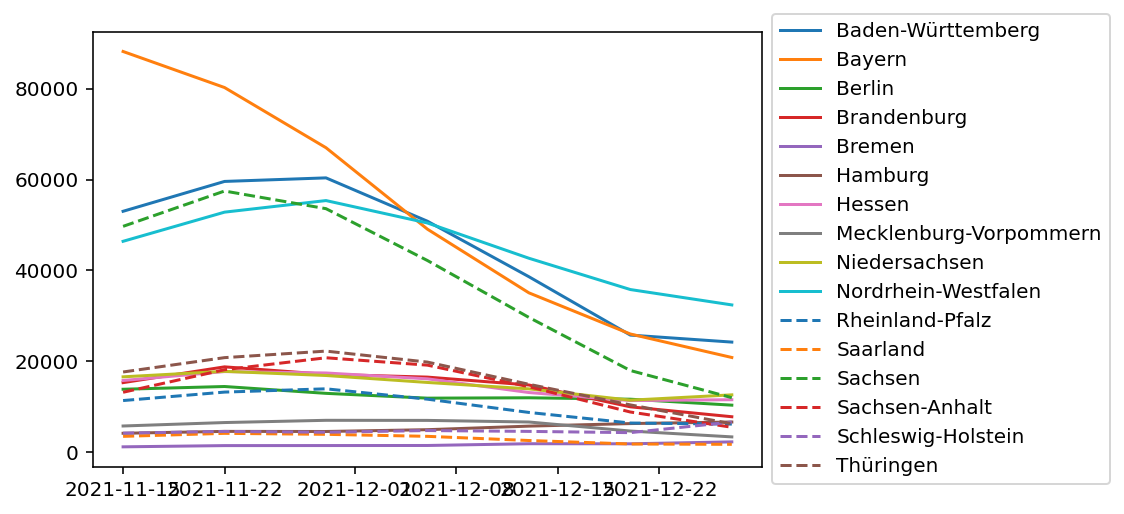

In [235]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] , label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [236]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] * c['prop'], label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('week')
plt.ylabel("Omicron cases")

Text(0, 0.5, 'Omicron cases')

In [237]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   211    0 -1212           168           1896   
                  2021-11-22  1533    1 -3864           588           6636   
                  2021-11-29   903    6 -3276           588           6636   
                  2021-12-06   954    9 -2688           588           6636   
                  2021-12-13   709   12 -2100           588           6636   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-06   143    0  -896           189           2135   
                  2021-12-13   240    0  -700           189           2135   
                  2021-12-20   166    0  -504           189           2135   
                  2021-12-27    73    5  -308           189           2135   
                  2022-01-03     0    0   -52            54            610   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000652  
                  2021-11-29  0.006645  
                  2021-12-06  0.009434  
                  2021-12-13  0.016925  
...                                ...  
Thüringen         2021-12-06  0.000000  
                  2021-12-13  0.000000  
                  2021-12-20  0.000000  
                  2021-12-27  0.068493  
                  2022-01-03       NaN  

[128 rows x 6 columns]

In [238]:
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-05         871
                  2022-01-06         640
                  2022-01-07         455
                  2022-01-08         417
                  2022-01-09         223

[11121 rows x 1 columns]

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


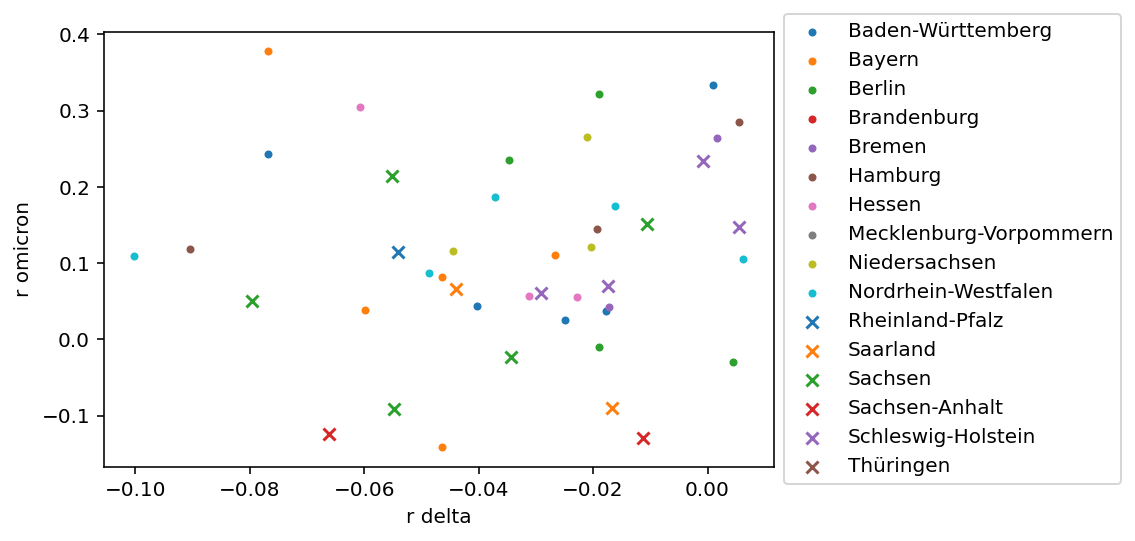

In [240]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    y = c['AnzahlFall'] * c['prop']
    x = c['AnzahlFall'] * (1-c['prop'])
    dx = np.log(x[1:]/x[:-1].values)/7
    dy = np.log(y[1:]/y[:-1].values)/7
    plt.scatter(dx, dy, label=r, marker = "." if i <10 else "x")
plt.xlabel("r delta")
plt.ylabel("r omicron")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [241]:
c = cases_land.loc[:,"2021-12-08":"2021-12-21",:] / cases_land.loc[:,"2021-12-01":"2021-12-14",:].values
foo = np.log(c).mean(level=0).rename(columns={'AnzahlFall':'r'}) / 7
foo['r_sd'] = np.log(c).std(level=0).values / 7

In [242]:
foo = foo.merge(pdf, left_index=True, right_index=True)

In [243]:
foo.plot.scatter("r","s", c = [f'C{i}' for i in range(foo.shape[0])])
#plt.legend()

<AxesSubplot:xlabel='r', ylabel='s'>

Text(0, 0.5, 'Growth rate Omicron')

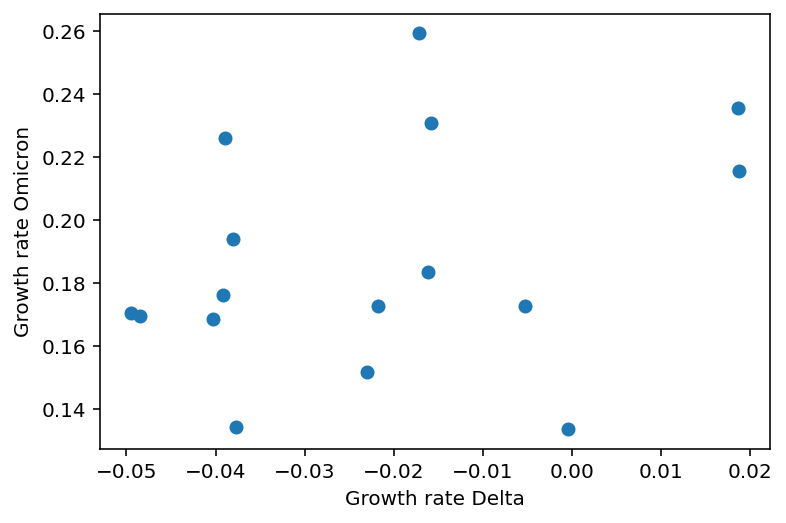

In [244]:
plt.scatter(foo['r'], foo['s'] + foo['r'])
plt.xlabel("Growth rate Delta")
plt.ylabel("Growth rate Omicron")

In [245]:
foo.to_csv(f"Germany_SGTF_{np.datetime64('today')}.csv")

In [246]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

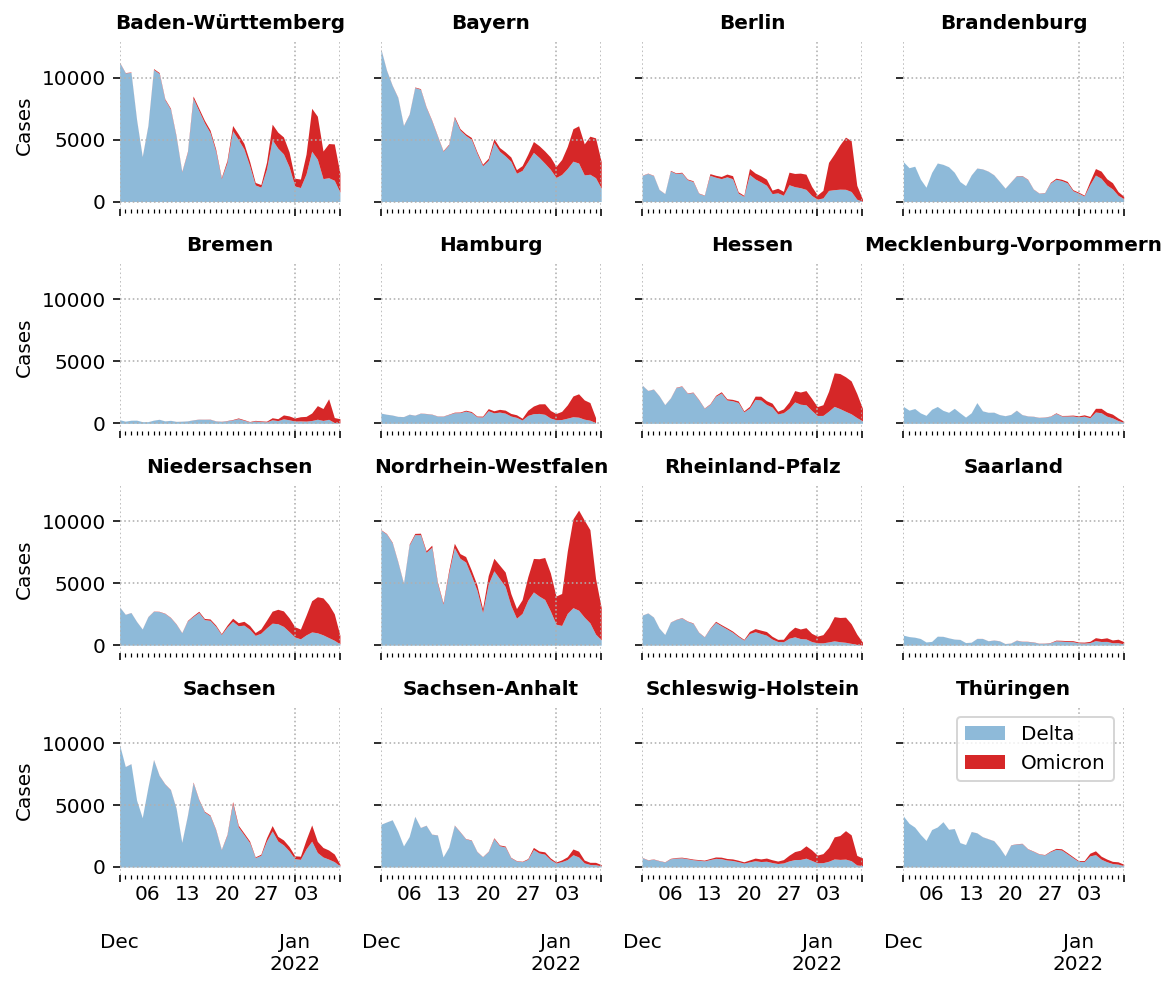

In [247]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] 
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = x[0.5] * y
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()

In [248]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = x[0.5] * y
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()